In [121]:
import numpy as np
import networkx as nx
import community
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
from scipy import sparse, stats, spatial
from sklearn import preprocessing, decomposition, model_selection
from pygsp import graphs, filters, plotting
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

from utils import load_text
from preprocess import text_to_graph
from graph import sparsity

init_notebook_mode(connected=True)

plt.rcParams['figure.figsize'] = (17, 5)
plotting.BACKEND = 'matplotlib'

%matplotlib inline
sns.set(rc={"figure.figsize": (15, 6)})
sns.set_palette(sns.color_palette("Set2", 10))

%reload_ext autoreload
%autoreload 2

In [211]:
cmap = {i: matplotlib.colors.to_hex(plt.cm.Set1.colors[i]) for i in range(len(plt.cm.Set1.colors))}
cmap

{0: '#e41a1c',
 1: '#377eb8',
 2: '#4daf4a',
 3: '#984ea3',
 4: '#ff7f00',
 5: '#ffff33',
 6: '#a65628',
 7: '#f781bf',
 8: '#999999'}

In [3]:
text = load_text("books/quran-shakir.txt")
text[:103]

'In the name of Allah, the Beneficent, the Merciful.\nAll praise is due to Allah, the Lord of the Worlds.'

In [278]:
nlinks = 4

occs, words_map = text_to_graph(text, ignore_stopwords=True, self_links=False, nlinks=nlinks, return_words_map=True)
words_map_inv = {e[1]:e[0] for e in words_map.items()}
occs += occs.T
print("Sparsity: {:05.2f}%".format(100 * sparsity(occs)))

Sparsity: 98.57%


In [279]:
words_map_inv = {e[1]:e[0] for e in words_map.items()}

In [280]:
len(occs[occs < 0])

0

In [281]:
Gn = nx.from_numpy_matrix(occs)

In [282]:
d = nx.degree(Gn)

In [283]:
betweenness = nx.betweenness_centrality(Gn,weight="weight")

In [284]:
for n in Gn.nodes():
    Gn.node[n]["betweenness"] = betweenness[n]

In [285]:
betweenness_scaled = {k: 4000*v + 20 for k,v in betweenness.items()}

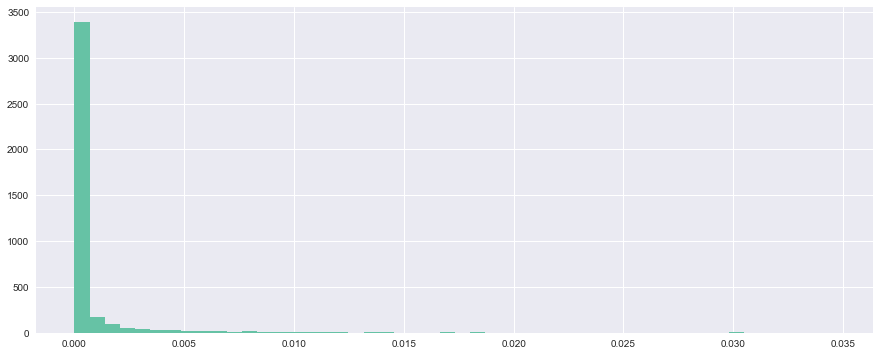

In [286]:
plt.hist(betweenness.values(), bins=50);

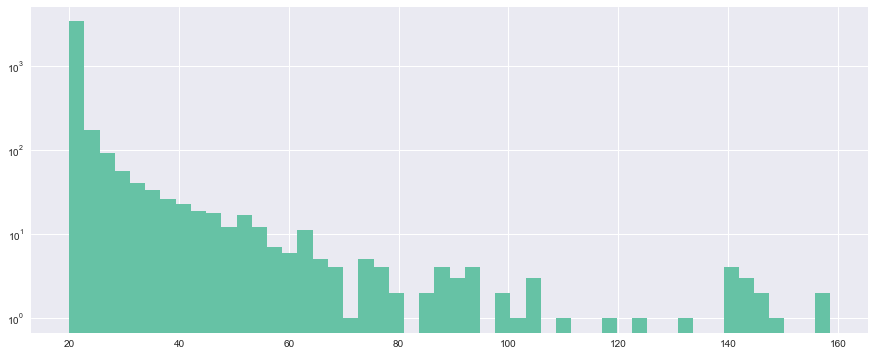

In [287]:
plt.hist(betweenness_scaled.values(), bins=50, log=True);

In [288]:
#first compute the best partition
partition = community.best_partition(Gn)

In [300]:
Gn.nodes()[0].get("betweenness")

0.0005807714092099715

In [289]:
partition_betweenness = community.best_partition(Gn, weight="betweenness")

In [290]:
#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(Gn)

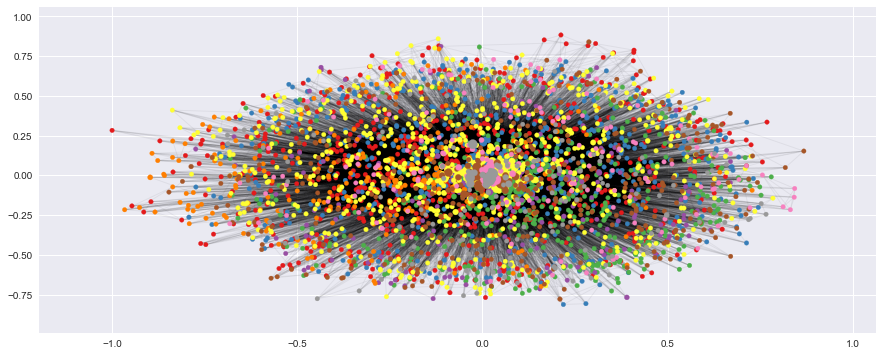

In [291]:
count = 0.

for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    sizes = [betweenness_scaled[node] for node in list_nodes]
    nx.draw_networkx_nodes(Gn, pos, list_nodes, node_size=sizes, node_color = cmap[com])

#str(count / size)
nx.draw_networkx_edges(Gn, pos, alpha=0.05)
plt.show()

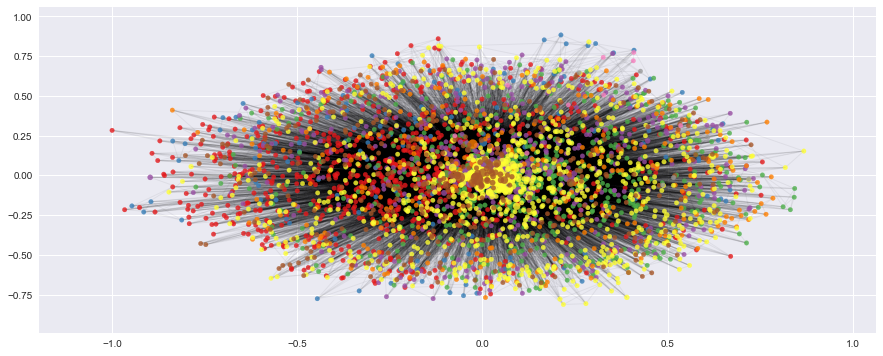

In [292]:
count = 0.

for com in set(partition_betweenness.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition_betweenness.keys()
                                if partition_betweenness[nodes] == com]
    sizes = [betweenness_scaled[node] for node in list_nodes]
    nx.draw_networkx_nodes(Gn, pos, list_nodes, node_size=sizes, node_color = cmap[com], alpha=0.8)

#str(count / size)
nx.draw_networkx_edges(Gn, pos, alpha=0.05)
plt.show()

In [293]:
Gnc = community.induced_graph(partition, Gn, weight='weight')

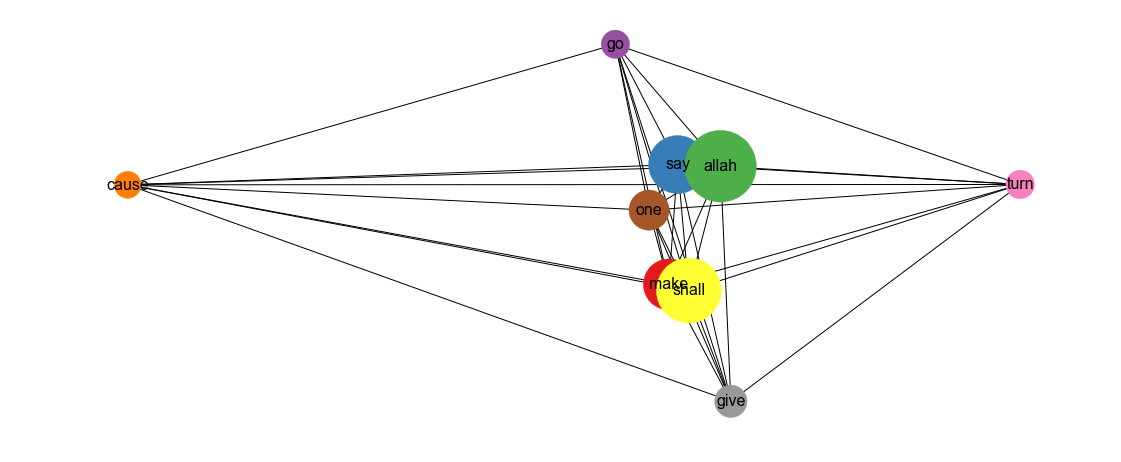

In [294]:
pos_gnc = nx.spring_layout(Gnc)
d_gnc = Gnc.degree(weight="weight")
sizes_gnc = [d_gnc[node] / 350 for node in Gnc.nodes()]
nx.draw(Gnc, pos=pos_gnc, node_size=sizes_gnc, node_color=[cmap[n] for n in Gnc.nodes()])

labels_gnc = {}
for com in Gnc.nodes():
    rep = max([nodes for nodes in partition.keys() if partition[nodes] == com], key=lambda n: Gn.degree(n, weight="weight"))
    labels_gnc[com] = words_map_inv[rep]

nx.draw_networkx_labels(Gnc,pos_gnc,labels_gnc,font_size=16);

In [302]:
Gncb = community.induced_graph(partition, Gn, weight='betweenness')

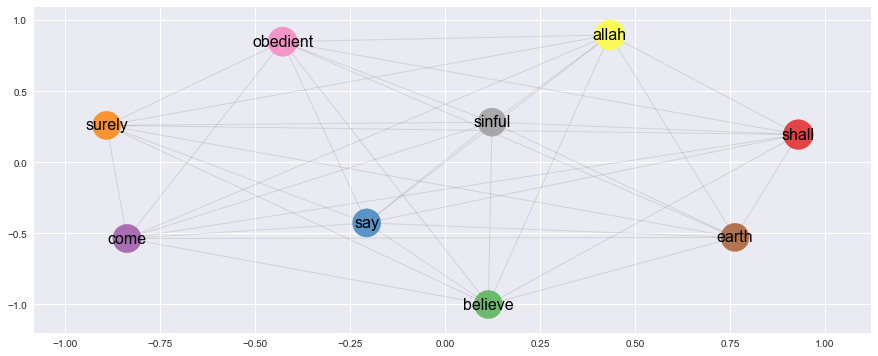

In [308]:
pos_gncb = nx.spring_layout(Gncb)
#d_gncb = Gncb.degree(weight="weight")
sizes_gncb = [betweenness_scaled[node]*40 for node in Gncb.nodes()]
nx.draw_networkx_nodes(Gncb, pos=pos_gncb, node_size=sizes_gncb, node_color=[cmap[n] for n in Gncb.nodes()], alpha=0.8)

labels_gncb = {}
for com in Gncb.nodes():
    rep = max([nodes for nodes in partition_betweenness.keys() if partition_betweenness[nodes] == com], key=lambda n: Gn.degree(n, weight="weight"))
    labels_gncb[com] = words_map_inv[rep]

nx.draw_networkx_edges(Gncb, pos_gncb, alpha=0.1)
nx.draw_networkx_labels(Gncb,pos_gncb,labels_gnc,font_size=16);

In [312]:
{n: Gnc.node[n] for n in Gnc.nodes()}

{0: {}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}}

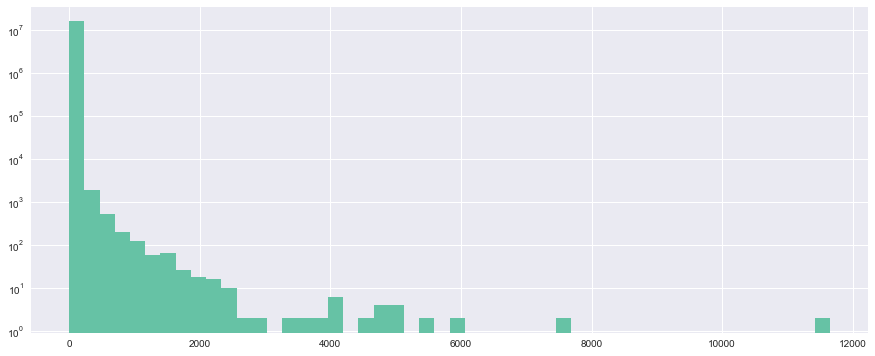

In [296]:
plt.hist(occs.reshape(-1), log=True, bins=50);

In [ ]:
Gn = nx.from_numpy_matrix(quran_graph)

In [92]:
max_occs = np.amax(occs)
zero_occ_dist = 10
distances = -(occs**2) + max_occs**2
#distances = -(zero_occ_dist / max_occs) * occs + zero_occ_dist

kernel_width = distances.mean()
weights = np.exp(-distances**2 / kernel_width**2)
# weights = weights + weights.T #Make undirected
np.fill_diagonal(weights, 0)

In [93]:
kernel_width

60332060.627628326

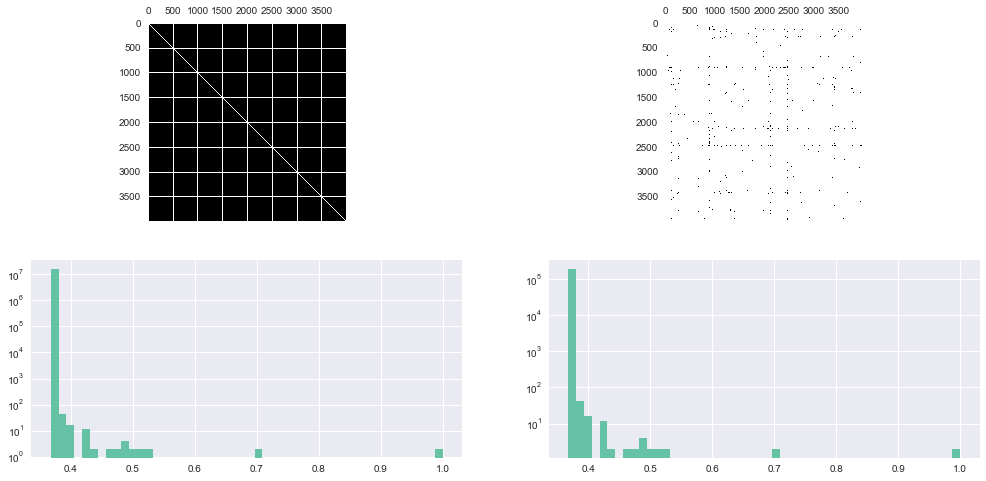

In [94]:
fix, axes = plt.subplots(2, 2, figsize=(17, 8))
def plot(weights, axes):
    axes[0].spy(weights)
    axes[1].hist(weights[weights > 0].reshape(-1), bins=50, log=True);
plot(weights, axes[:, 0])

NEIGHBORS = 100
weights_sorted = weights.copy()
weights_sorted.sort()
# The threshold element, if a value is below, we will discard it.
weights_threshold = weights_sorted[:,weights.shape[0]-NEIGHBORS]
weights_sparse = weights * (weights.T > weights_threshold).T
# weights_sparse = weights * (np.argsort(weights) >= (weights.shape[0]-NEIGHBORS))

weights_sparse = weights_sparse - (weights_sparse - weights_sparse.T)
weights_sparse_sym_tool = weights_sparse - weights_sparse.T
weights_sparse = weights_sparse - weights_sparse_sym_tool*(weights_sparse_sym_tool < 0)

plot(weights_sparse, axes[:, 1])

In [95]:
G = graphs.Graph(weights, gtype='Occurences')

In [96]:
G.compute_laplacian('normalized')

In [97]:
G.compute_fourier_basis(recompute=True)

2018-01-21 19:08:11,116:[WARNING](pygsp.graphs.graph.compute_fourier_basis): Computing the full eigendecomposition of a large matrix (3990 x 3990) may take some time.


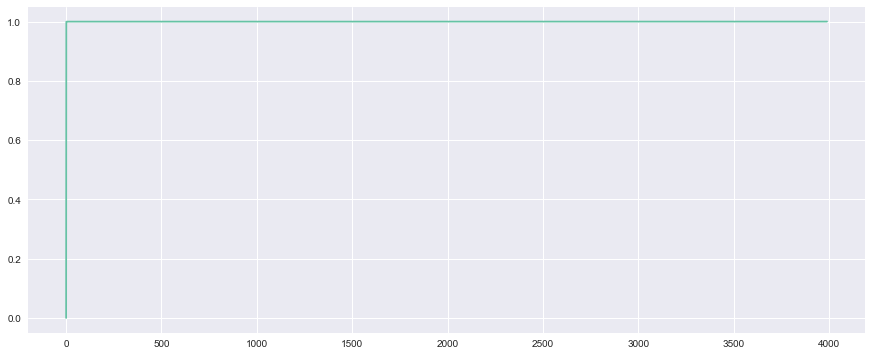

In [98]:
plt.plot(G.e);

In [21]:
G.set_coordinates()

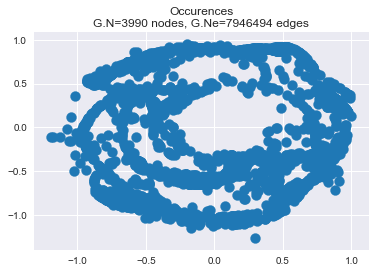

In [22]:
G.plot()

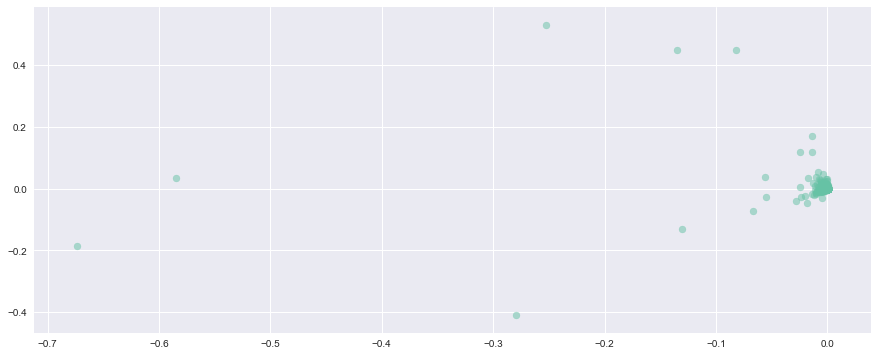

In [99]:
x = G.U[:,1]
y = G.U[:,2]
plt.scatter(x, y, cmap='RdBu', alpha=0.5);

In [100]:
trace = go.Scatter3d(
    x=G.U[:, 1],
    y=G.U[:, 2],
    z=G.U[:, 3],
    name='a',
    mode='markers',
    marker=dict(
        size=12,
        color='b',
        #colorscale='Viridis',
        #opacity=0.8,
        line=dict(
            width=2,
            color='black'
        )
    )
)

In [ ]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

In [101]:
layout = go.Layout(
    hovermode= 'closest',
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

In [102]:
data = [trace]

fig = go.Figure(data=data, layout=layout)
iplot(fig)